## Импорт библиотек и загрузка данных

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [3]:
import tensorflow as tf

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
from sklearn.datasets import load_boston
from sklearn.cross_validation import train_test_split
boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target, test_size=0.3)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [5]:
# normalization
x_mean = X_train.mean(axis=0)
x_std = X_train.std(axis=0)
X_train = (X_train - x_mean) / x_std
X_test = (X_test - x_mean) / x_std

## Построение и запуск простейшей нейросети

In [6]:
t = tf.constant(np.arange(9))
t = tf.reshape(t, [3, 3])

In [7]:
from ipywidgets import IntProgress
from tqdm import tqdm_notebook

In [8]:
class SimpleNN():
    def __init__(self, input_dim=64, hidden_size=32, output_dim=1):
        xavier = np.sqrt(6.0/(input_dim+hidden_size))
        xavier2 = np.sqrt(6.0/(output_dim+hidden_size))
        self.hidden_weights = tf.Variable(tf.random_uniform((input_dim, hidden_size),
                                                    minval=-xavier, maxval=xavier, dtype=tf.float64),
                                  name='hidden_weights')
        self.hidden_bias = tf.Variable(tf.random_uniform((hidden_size,),
                                                         minval=-xavier, maxval=xavier, dtype=tf.float64), 
                                       name='hidden_bias')
        self.output_weights = tf.Variable(tf.random_uniform((hidden_size, output_dim),
                                                            minval=-xavier2, maxval=xavier2, dtype=tf.float64), 
                                          name='output_weights')
        self.output_bias = tf.Variable(tf.random_uniform((output_dim,), minval=-xavier2, maxval=xavier2, dtype=tf.float64), 
                                       name='output_bias')
        
        self.hidden_opt_matrix = np.ones(self.hidden_weights.shape)
        self.output_opt_matrix = np.ones(self.output_weights.shape)
        
        self.X = tf.placeholder(tf.float64, [None, input_dim])
        self.Y = tf.placeholder(tf.int32, [None, 1])
        self.hidden_layer = tf.nn.tanh(tf.add(self.hidden_bias, tf.matmul(self.X, self.hidden_weights)))
        self.output = tf.nn.relu(tf.add(self.output_bias, tf.matmul(self.hidden_layer, self.output_weights)))
        self.prediction = self.output
        
        self.sess = tf.Session()
        
        
    def fit(self, 
            X_train,
            y_train,
            batch_size=64, 
            val_data=None, 
            steps=1000,
            learning_rate=1.0,
            verbose_freq=0,
            warm_start=False,
            print_out=False):
        
        self.X_train = X_train
        self.y_train = y_train[:, np.newaxis]
        
        train_history = []
        val_history = []
        
        #normalization
        x_mean = X_train.mean(axis=0)
        x_std = X_train.std(axis=0)
        epsilon = 1e-8
        X_train = (X_train - x_mean) / (x_std + epsilon) #to prevent zero division
        if val_data is not None:
            X_val, y_val = val_data
            X_val = (X_val - x_mean) / (x_std + epsilon)
            
        #creating computation graph
        init_op = tf.global_variables_initializer()
        if not warm_start:
            self.sess.run(init_op)
        loss_function = tf.reduce_mean(tf.losses.mean_squared_error(self.Y, self.output))
        optimizer = tf.train.GradientDescentOptimizer(learning_rate)
        optimization = optimizer.minimize(loss_function)

        for i in tqdm_notebook(np.arange(steps)):
            #train step
            ids = np.random.choice(np.arange(len(X_train)), size=batch_size)
            batch = X_train[ids]
            labels = y_train[ids]
            prediction = self.sess.run(self.prediction, feed_dict={self.X:batch})
            _, loss = self.sess.run([optimization, loss_function],  
                                    feed_dict={self.X: batch, self.Y: labels[:, np.newaxis]})

            if verbose_freq > 0 and i % verbose_freq == 0:
                train_prediction = self.sess.run(self.prediction, feed_dict={self.X:X_train})
                val_prediction = self.sess.run(self.prediction, feed_dict={self.X:X_val})
                train_loss = np.mean((train_prediction.ravel() - y_train) ** 2)
                val_loss = np.mean((val_prediction.ravel() - y_val) ** 2)
                train_history.append(train_loss)
                val_history.append(val_loss)
                
                if print_out:
                    print('step number', i)
                    print('loss', loss)
                    print('train acc', train_acc)
                    print('val acc', val_acc)
        return train_history, val_history
                
    
    def predict(self, X_test):
        return self.sess.run(self.prediction, feed_dict={self.X:X_test})
    
    
    def get_gradients(self, warm_start=True):
        if not warm_start:
            init_op = tf.global_variables_initializer()
            self.sess.run(init_op)
        loss_function = tf.reduce_mean(tf.losses.mean_squared_error(self.Y, self.output))
        optimizer = tf.train.GradientDescentOptimizer(1.)
        gradients = optimizer.compute_gradients(loss_function, 
                                                var_list=[self.hidden_weights,
                                                          self.hidden_bias, 
                                                          self.output_weights,
                                                          self.output_bias])
        grad_vals, loss = self.sess.run([gradients, loss_function],  
                                   feed_dict={self.X: self.X_train, self.Y: self.y_train})
        return [x[0] for x in grad_vals]
    
    
    def fit_with_conditions(self, 
            X_train,
            y_train,
            batch_size=64, 
            warm_start=True,
            val_data=None, 
            steps=1000,
            learning_rate=1.0,
            verbose_freq=0,
            print_out=False):
        
        self.X_train = X_train
        self.y_train = y_train
        
        if val_data is not None:
            X_val, y_val = val_data
        
        train_history = []
        val_history = []
            
        #creating computation graph
        optimizer = tf.train.GradientDescentOptimizer(learning_rate)
        loss_function = tf.losses.mean_squared_error(self.Y, self.output)
        gradients = optimizer.compute_gradients(loss_function, var_list=[self.hidden_weights,
                                                               self.hidden_bias,
                                                               self.output_weights,
                                                               self.output_bias])
    
        hidden_weights_grad, hidden_bias_grad, output_weights_grad, output_bias_grad = [x[0] for x in gradients[:4]]

        new_hidden_weights = (self.hidden_weights) - learning_rate * hidden_weights_grad * self.hidden_opt_matrix
        new_hidden_bias = self.hidden_bias - learning_rate * hidden_bias_grad
        new_output_weights = self.output_weights - learning_rate * output_weights_grad * self.output_opt_matrix
        new_output_bias = self.output_bias  - learning_rate * output_bias_grad
        update_hidden_w = self.hidden_weights.assign(new_hidden_weights)
        update_hidden_b = self.hidden_bias.assign(new_hidden_bias)
        update_out_w = self.output_weights.assign(new_output_weights)
        update_out_b = self.output_bias.assign(new_output_bias)
        self.hidden_layer = tf.nn.tanh(tf.add(self.hidden_bias, tf.matmul(self.X, self.hidden_weights)))
        self.output = tf.nn.relu(tf.add(self.output_bias, tf.matmul(self.hidden_layer, self.output_weights)))
        self.prediction = self.output

        for i in tqdm_notebook(np.arange(steps)):
            ids = np.random.choice(np.arange(len(X_train)), size=batch_size)
            batch = X_train[ids]
            labels = y_train[ids]
            labels = labels[:, np.newaxis]
            self.sess.run([update_hidden_w,update_hidden_b, update_out_w, update_out_b ],
                          feed_dict={self.X: batch, self.Y: labels})
            
            if verbose_freq > 0 and i % verbose_freq == 0:
                train_prediction = self.sess.run(self.prediction, feed_dict={self.X:X_train})
                val_prediction = self.sess.run(self.prediction, feed_dict={self.X:X_val})
                train_loss = np.mean((train_prediction.ravel() - y_train) ** 2)
                val_loss = np.mean((val_prediction.ravel() - y_val) ** 2)
                train_history.append(train_loss)
                val_history.append(val_loss)
                
                if print_out:
                    print('step number', i)
                    print('loss', loss)
                    print('train acc', train_acc)
                    print('val acc', val_acc)
        return train_history, val_history

    
    def disable_optimization(self, alpha, method='min_grad'):
        #disables optimization for alpha * n_params parameters which have minimal value of gradient of loss
        if method == 'min_grad':
            gradients = self.get_gradients()
            hidden_gradients = gradients[0]
            hidden_gradients_ravel = hidden_gradients.ravel()
            output_gradients = gradients[2]
            output_gradients_ravel = output_gradients.ravel()
            
            hidden_off = np.argsort(np.abs(hidden_gradients_ravel))[:int(alpha * len(hidden_gradients_ravel))]
            output_off = np.argsort(np.abs(output_gradients_ravel))[:int(alpha * len(output_gradients_ravel))]
            
            hidden_opt_matrix = np.ones(hidden_gradients_ravel.shape)
            hidden_opt_matrix[hidden_off] = 0
            hidden_opt_matrix = hidden_opt_matrix.reshape(self.hidden_weights.shape)
            output_opt_matrix = np.ones(output_gradients_ravel.shape)
            output_opt_matrix[output_off] = 0
            output_opt_matrix = output_opt_matrix.reshape(self.output_weights.shape)
            self.hidden_opt_matrix = hidden_opt_matrix
            self.output_opt_matrix = output_opt_matrix        
    
    
    def prune(self, alpha, method='min_weight', warm_start=True):
        #cuts off alpha*n_params parameters with minimal weights
        if not warm_start:
            init_op = tf.global_variables_initializer()
            self.sess.run(init_op)
        if method == 'min_weight':
            hidden_weights = self.sess.run(self.hidden_weights)
            output_weights = self.sess.run(self.output_weights)
            hidden_weights_ravel = hidden_weights.ravel()
            hidden_argsort = np.argsort(np.abs(hidden_weights_ravel))
            output_weights_ravel = output_weights.ravel()
            output_argsort = np.argsort(np.abs(output_weights_ravel))
            n_hidden_to_cut = int(alpha * hidden_weights_ravel.size)
            n_output_to_cut = int(alpha * output_weights_ravel.size)
            hidden_threshold = (np.abs(hidden_weights_ravel[hidden_argsort[n_hidden_to_cut - 1]]) + \
                               np.abs(hidden_weights_ravel[hidden_argsort[n_hidden_to_cut]])) / 2
            output_threshold = (np.abs(output_weights_ravel[output_argsort[n_output_to_cut - 1]]) + \
                               np.abs(output_weights_ravel[output_argsort[n_output_to_cut]])) / 2
            if n_hidden_to_cut == 0:
                hidden_threshold = -np.inf
            if n_output_to_cut == 0:
                output_threshold = -np.inf
            
            #print(type(self.hidden_opt_matrix), self.hidden_opt_matrix.shape)
            self.hidden_opt_matrix[hidden_weights < hidden_threshold] = 0
            self.output_opt_matrix[output_weights < output_threshold] = 0
            hidden_weights[hidden_weights < hidden_threshold] = 0
            output_weights[output_weights < output_threshold] = 0
            self.sess.run(self.hidden_weights.assign(hidden_weights))
            self.sess.run(self.output_weights.assign(output_weights))

Попробуем сначала запустить 500 шагов обычной оптимизации, затем еще 5000 шагов обычной оптимизации, и посмотреть на графики ошибки на трейне и тесте

In [9]:
simple_nn = SimpleNN(input_dim=X_train.shape[1])

In [10]:
history = simple_nn.fit(X_train,
                        y_train,
                        batch_size=50,
                        learning_rate=1e-3,
                        val_data=(X_test, y_test),
                        steps=500,
                        verbose_freq=1,
                        warm_start=False,
                        print_out=False)

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

Text(0,0.5,'mse')

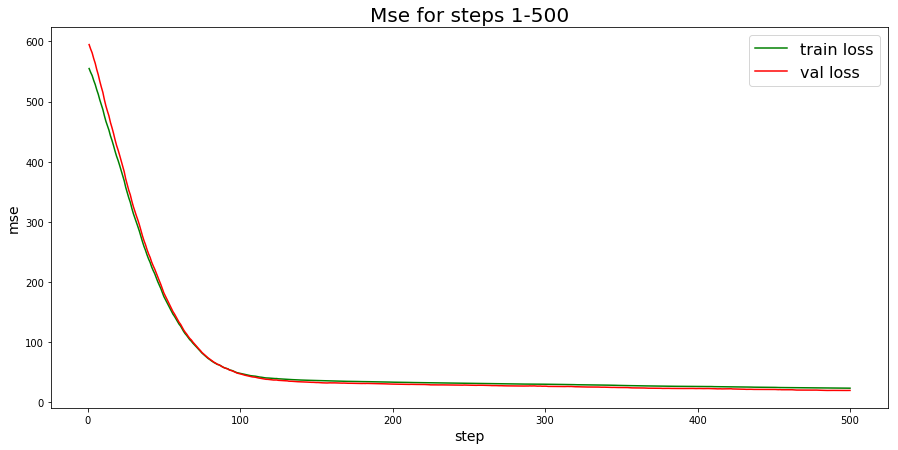

In [11]:
train_loss, val_loss = history
plt.figure(figsize=(15, 7))
steps = np.arange(1, 501)
plt.title('Mse for steps 1-500', fontsize=20)
plt.plot(steps, train_loss, color='g', label='train loss')
plt.plot(steps, val_loss, color='r', label='val loss')
plt.legend(fontsize=16)
plt.xlabel('step', fontsize=14)
plt.ylabel('mse', fontsize=14)

In [12]:
history = simple_nn.fit(X_train,
                        y_train,
                        batch_size=50,
                        learning_rate=1e-3,
                        val_data=(X_test, y_test),
                        steps=5000,
                        verbose_freq=1,
                        warm_start=True,
                        print_out=False)

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

Text(0,0.5,'mse')

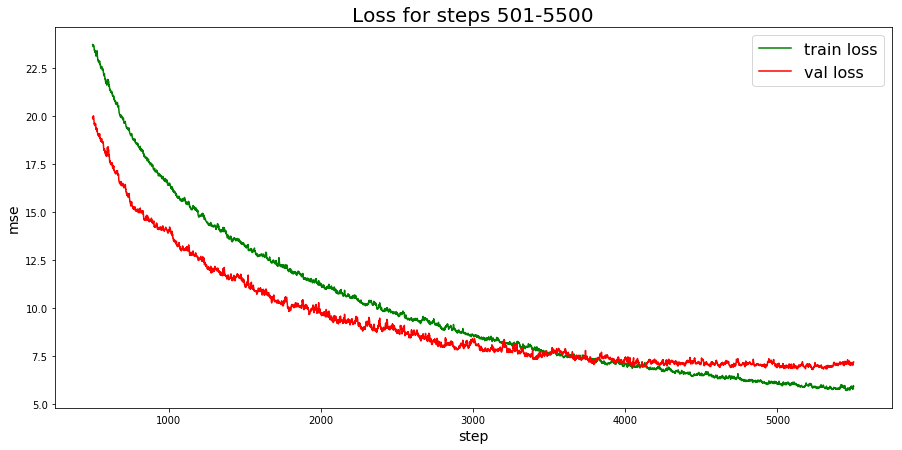

In [13]:
train_loss, val_loss = history
plt.figure(figsize=(15, 7))
steps = np.arange(501, 5501)
plt.title('Loss for steps 501-5500', fontsize=20)
plt.plot(steps, train_loss, color='g', label='train loss')
plt.plot(steps, val_loss, color='r', label='val loss')
plt.legend(fontsize=16)
plt.xlabel('step', fontsize=14)
plt.ylabel('mse', fontsize=14)

In [14]:
print('last train', train_loss[-1])
print('last valid', val_loss[-1])

last train 5.912854504435466
last valid 7.188575320250807


Теперь с обрезанием и отключением оптимизации: сначала 500 шагов обычной оптимизации, затем отключим оптимизацию для 50% параметров и вырежем 20% параметров, и запустим еще 5000 шагов оптимизации

In [15]:
simple_nn = SimpleNN(input_dim=X_train.shape[1])

In [16]:
history = simple_nn.fit(X_train,
                        y_train,
                        batch_size=50,
                        learning_rate=1e-3,
                        val_data=(X_test, y_test),
                        steps=500,
                        verbose_freq=1,
                        print_out=False)

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

Text(0,0.5,'mse')

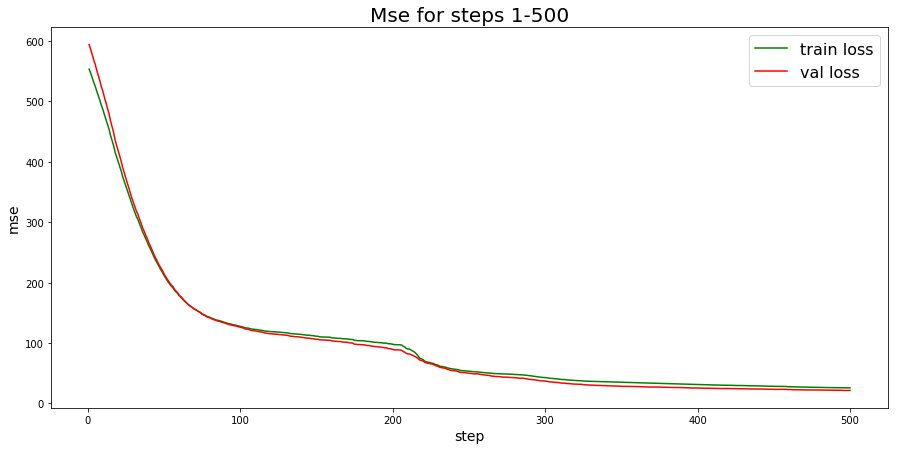

In [17]:
train_loss, val_loss = history
plt.figure(figsize=(15, 7))
steps = np.arange(1, 501)
plt.title('Mse for steps 1-500', fontsize=20)
plt.plot(steps, train_loss, color='g', label='train loss')
plt.plot(steps, val_loss, color='r', label='val loss')
plt.legend(fontsize=16)
plt.xlabel('step', fontsize=14)
plt.ylabel('mse', fontsize=14)

In [18]:
print('last train loss:', train_loss[-1])
print('last valid loss:', val_loss[-1])

last train loss: 25.7731339406647
last valid loss: 21.47291089531123


In [19]:
simple_nn.disable_optimization(0.5)
simple_nn.prune(0.0)

In [20]:
history = simple_nn.fit_with_conditions(X_train,
                        y_train,
                        batch_size=50,
                        learning_rate=1e-3,
                        val_data=(X_test, y_test),
                        steps=5000,
                        verbose_freq=1,
                        warm_start=True,
                        print_out=False)

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

Text(0,0.5,'mse')

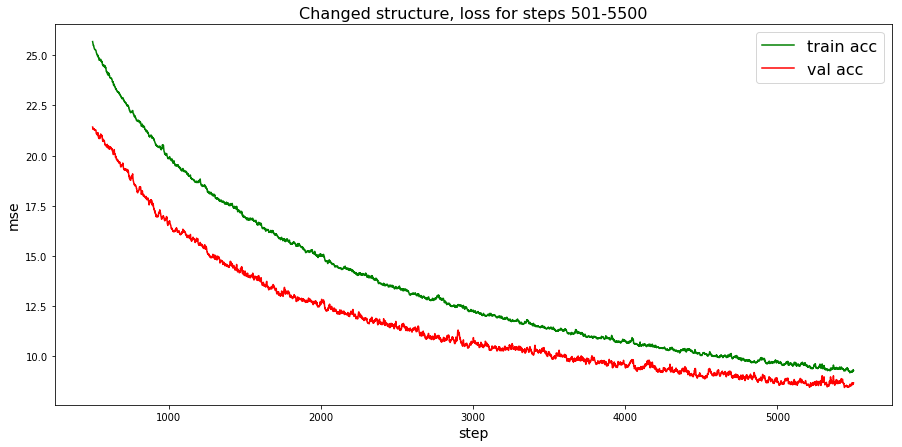

In [21]:
train_loss, val_loss = history
plt.figure(figsize=(15, 7))
steps = np.arange(501, 5501)
plt.title('Changed structure, loss for steps 501-5500', fontsize=16)
plt.plot(steps, train_loss, color='g', label='train acc')
plt.plot(steps, val_loss, color='r', label='val acc')
plt.legend(fontsize=16)
plt.xlabel('step', fontsize=14)
plt.ylabel('mse', fontsize=14)

In [22]:
print('last train loss:', train_loss[-1])
print('last valid loss:', val_loss[-1])

last train loss: 9.286793678197457
last valid loss: 8.671127125434083


## График зависимости ошибки от числа зануленных параметров и числа зануленных градиентов

In [23]:
p_disabled = np.linspace(0, 1, 50)

In [24]:
import gc

In [25]:
train_losses_disable = []
validation_losses_disable = []
simple_nn = SimpleNN(input_dim=X_train.shape[1])

for _ in range(5):
    train_losses_disable.append([])
    validation_losses_disable.append([])
    for p in p_disabled:
        del simple_nn
        gc.collect()
        simple_nn = SimpleNN(input_dim=X_train.shape[1])
        history = simple_nn.fit(X_train,
                            y_train,
                            batch_size=50,
                            learning_rate=1e-3,
                            val_data=(X_test, y_test),
                            steps=500,
                            verbose_freq=499,
                            warm_start=False,
                            print_out=False)

        simple_nn.disable_optimization(p)
        history = simple_nn.fit_with_conditions(X_train,
                            y_train,
                            batch_size=50,
                            learning_rate=1e-3,
                            val_data=(X_test, y_test),
                            steps=5000,
                            verbose_freq=4999,
                            warm_start=True,
                            print_out=False)
        train_loss, val_loss = history
        train_losses_disable[-1].append(train_loss[-1])
        validation_losses_disable[-1].append(val_loss[-1])

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

In [26]:
try:
    train_losses_disable = np.array(train_losses_disable)
    validation_losses_disable = np.array(validation_losses_disable)
    np.savetxt('./train_losses_disable.txt', train_losses_disable)
    np.savetxt('./validation_losses_disable.txt', validation_losses_disable)
except:
    pass

In [28]:
train_loss_disable_mean = np.mean(train_losses_disable, axis=0)
val_loss_disable_mean = np.mean(validation_losses_disable, axis=0)

(50,)


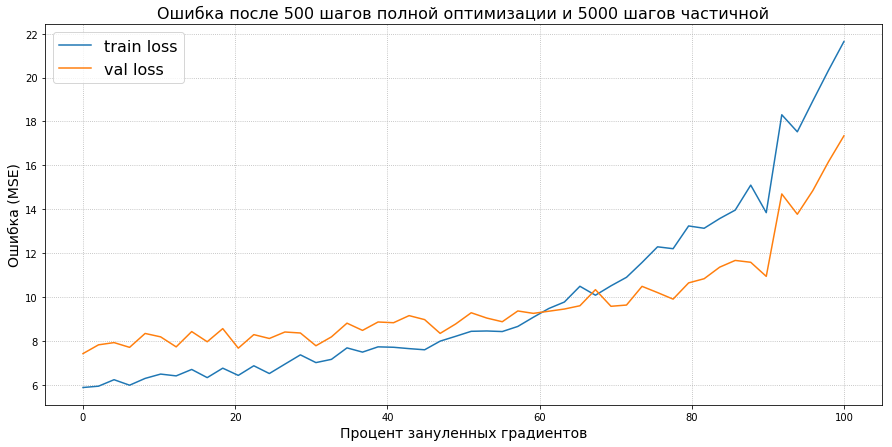

In [37]:
plt.figure(figsize=(15, 7))
plt.title('Ошибка после 500 шагов полной оптимизации и 5000 шагов частичной', fontsize=16)
plt.plot(p_disabled * 100, train_loss_disable_mean, label='train loss')
plt.plot(p_disabled * 100, val_loss_disable_mean, label='val loss')
plt.legend(fontsize=16)
plt.xlabel('Процент зануленных градиентов', fontsize=14)
plt.ylabel('Ошибка (MSE)', fontsize=14)
plt.grid(ls=':')

In [ ]:
p_cut = np.linspace(0, 1, 50)

In [31]:
train_losses_prune = []
validation_losses_prune = []

simple_nn = SimpleNN(input_dim=X_train.shape[1])
for _ in range(5):
    train_losses_prune.append([])
    validation_losses_prune.append([])
    for p in p_cut[:-1]:
        del simple_nn
        gc.collect()
        simple_nn = SimpleNN(input_dim=X_train.shape[1])
        history = simple_nn.fit(X_train,
                            y_train,
                            batch_size=50,
                            learning_rate=1e-3,
                            val_data=(X_test, y_test),
                            steps=500,
                            verbose_freq=499,
                            warm_start=False,
                            print_out=False)

        simple_nn.prune(p)
        history = simple_nn.fit_with_conditions(X_train,
                            y_train,
                            batch_size=50,
                            learning_rate=1e-3,
                            val_data=(X_test, y_test),
                            steps=5000,
                            verbose_freq=4999,
                            warm_start=True,
                            print_out=False)
        train_loss, val_loss = history
        train_losses_prune[-1].append(train_loss[-1])
        validation_losses_prune[-1].append(val_loss[-1])

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

In [32]:
train_losses_prune = np.array(train_losses_prune)
validation_losses_prune = np.array(validation_losses_prune)
np.savetxt('./train_losses_prune.txt', train_losses_prune)
np.savetxt('./validation_losses_prune.txt', validation_losses_prune)

In [33]:
mean_train_loss_prune = train_losses_prune.mean(axis=0)
mean_val_loss_prune = validation_losses_prune.mean(axis=0)
print(mean_train_loss_prune.shape)

(49,)


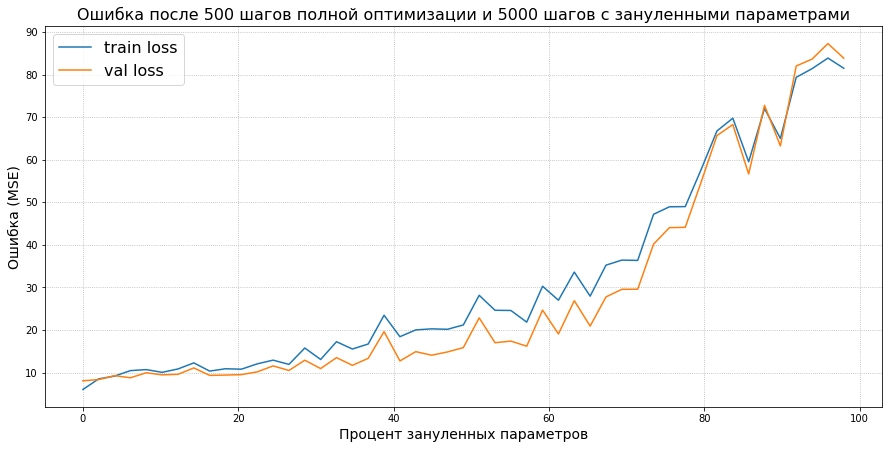

In [38]:
plt.figure(figsize=(15, 7))
plt.title('Ошибка после 500 шагов полной оптимизации и 5000 шагов с зануленными параметрами', fontsize=16)
plt.plot(p_cut[:-1] * 100, mean_train_loss_prune, label='train loss')
plt.plot(p_cut[:-1] * 100, mean_val_loss_prune, label='val loss')
plt.legend(fontsize=16)
plt.xlabel('Процент зануленных параметров', fontsize=14)
plt.ylabel('Ошибка (MSE)', fontsize=14)
plt.grid(ls=':')